# Model Group Pairwise Comparison

In [2]:
import numpy as np
from itertools import combinations, permutations
class GroupPairwiseComparator:
    """
        This class aims to provide a framework for pairwise comparison-based sorting algorithms.
        Different algorithms can be implemented as different methods.
    """
    def __init__(self, items : list, comparison_matrix=None):
        """
            Args:
                items (`List[Any]`) : group elements
                comparison_matrix (`Optional[np.ndarray]`) : comparison matrix `m`, where each `m[i,j]` is in `[0,1]`. `m[i,j] == 0` means `i` is 'smaller' than `j`.
                
        """
        self.n = len(items)
        self.items = items
        self.comparison_matrix = np.zeros((self.n, self.n), dtype=int) if comparison_matrix is None else np.array(comparison_matrix)

    def reset_comparisons(self):
        """
            Reset the comparison matrix to all zeros.
        """
        self.comparison_matrix = np.zeros((self.n, self.n), dtype=int)

    def is_compared(self, i : int, j : int):
        """
            Check if items[i] and items[j] have been compared.
        """
        assert i != j, ValueError(f"Cannot check comparison for the same item {i} == {j}.")
        return self.comparison_matrix[i][j] != 0 or self.comparison_matrix[j][i] != 0

    def add_comparison(self, i : int, j : int, result : int):
        """
            Add a comparison result between items[i] and items[j].
            result should be 1 if items[i] is better than items[j], else 0.
        """
        assert i != j, ValueError(f"Cannot add comparison for the same item {i} == {j}.")
        assert result in [0, 1], ValueError(f"Comparison result must be 0 or 1, got {result}.")
        self.comparison_matrix[i][j] = result
        self.comparison_matrix[j][i] = 1 - result

    def compare(self, i : int, j : int, reverse=False):
        """
            Compare items[i] and items[j].
            Return True if items[i] is *smaller* than items[j] (for ascending order), else False.
            This function should be consistent at least, which means one and only one of a > b, a < b is True (assume no equality).
            The comparison may not be transitive, i.e., a > b and b > c does not necessarily imply a > c (refer to real-world scenarios).
        """
        assert i != j, ValueError(f"Cannot compare the same item {i} == {j}.")

        is_compared = self.is_compared(i, j)
        if not is_compared:
            # Random comparison as placeholder
            win = np.random.choice([0, 1])
            self.comparison_matrix[i][j] = win
            self.comparison_matrix[j][i] = 1 - win

        return self.comparison_matrix[i][j] == (1 if reverse else 0)

    def quick_sort(self, reverse=False, return_comparison_count=False):
        """
            Perform quicksort on self.items using pairwise comparisons.
            This algorithm *requires* the assumption that the comparison function is consistent and transitive.
        """
        cmp_cnt = 0
        arr = list(range(self.n))
        def partition(low, high):
            pivot = arr[high]
            i = low - 1
            
            for j in range(low, high):
                nonlocal cmp_cnt
                cmp_cnt += 1
                if self.compare(arr[j], pivot, reverse=reverse):
                    i += 1
                    arr[i], arr[j] = arr[j], arr[i]
            
            arr[i + 1], arr[high] = arr[high], arr[i + 1]
            return i + 1
        
        def quicksort_helper(low=0, high=None):
            if high is None:
                high = self.n - 1
            if low < high:
                pi = partition(low, high)
                quicksort_helper(low, pi - 1)
                quicksort_helper(pi + 1, high)

        quicksort_helper()
        if return_comparison_count:
            return [self.items[i] for i in arr], cmp_cnt
        
        return [self.items[i] for i in arr]

    
    def tournament_sort(self, reverse=False, return_comparison_count=False):
        """
            Perform tournament sort on self.items using pairwise comparisons.
            This algorithm *does not* require the assumption that the comparison function is transitive.
        """
        cmp_cnt = 0
        arr = list(range(self.n))
        tmp = [0] * (2 * self.n)

        def build_tournament():
            for i in range(self.n):
                tmp[self.n + i] = arr[i]
            for i in range(self.n - 1, 0, -1):
                left = tmp[2 * i]
                right = tmp[2 * i + 1]
                nonlocal cmp_cnt
                cmp_cnt += 1
                if self.compare(left, right, reverse=reverse):
                    tmp[i] = left
                else:
                    tmp[i] = right

        def update_tournament(winner_index):
            idx = (self.n + winner_index) // 2
            while idx > 0:
                left = tmp[2 * idx]
                right = tmp[2 * idx + 1]

                if left == -1:
                    tmp[idx] = right
                    idx //= 2
                    continue

                if right == -1:
                    tmp[idx] = left
                    idx //= 2
                    continue

                nonlocal cmp_cnt
                cmp_cnt += 1
                if self.compare(left, right, reverse=reverse):
                    tmp[idx] = left
                else:
                    tmp[idx] = right
                idx //= 2

        sorted_items = []
        build_tournament()
        for _ in range(self.n):
            winner = tmp[1]
            sorted_items.append(self.items[winner])
            winner_index = arr.index(winner)
            arr[winner_index] = -1  # Mark as removed
            tmp[self.n + winner_index] = -1  # Mark as removed in tournament tree
            update_tournament(winner_index)

        if return_comparison_count:
            return sorted_items, cmp_cnt
        
        return sorted_items
    
    def swiss_sort(self, reverse=False, return_comparison_count=False):
        """
            Perform Swiss-system tournament sort on self.items using pairwise comparisons.
            This algorithm *does not* require the assumption that the comparison function is transitive.
        """
        cmp_cnt = 0
        arr = list(range(self.n))
        scores = [0] * self.n
        rounds = int(np.ceil(np.log2(self.n))) + 1  # Number of rounds

        for _ in range(rounds):
            np.random.shuffle(arr)
            for i in range(0, self.n - 1, 2):
                cmp_cnt += 1
                if self.compare(arr[i], arr[i + 1], reverse=reverse):
                    # If `compare` gives True, see it as arr[i] wins
                    scores[arr[i]] += 1
                else:
                    scores[arr[i + 1]] += 1

        sorted_indices = sorted(range(self.n), key=lambda x: scores[x], reverse=True)
        sorted_items = [self.items[i] for i in sorted_indices]

        if return_comparison_count:
            return sorted_items, cmp_cnt
        
        return sorted_items

In [3]:
def generate_cmp_matrix(n, transitive=False):
    cmp_matrix = np.zeros((n,n), dtype=np.float64)
    if transitive:
        # Genrate a list of random number for comparison
        scores = np.random.randn(n)
        for i, j in combinations(range(n), 2):
            win = int(scores[i] > scores[j])
            cmp_matrix[i,j] = win
            cmp_matrix[j,i] = 1 - win
    else:
        # Generate n*(n-1)/2 pairs winning scores
        for i, j in combinations(range(n), 2):
            win = np.random.randint(0, 2)
            cmp_matrix[i,j] = win
            cmp_matrix[j,i] = 1 - win

    return cmp_matrix

In [10]:
group_size = 10
group = [chr(i) for i in range(65, 65 + group_size)]  # A-Z
# cmp_matrix = np.tril(np.ones((group_size, group_size), dtype=int), k=-1)  # Upper triangle matrix
cmp_matrix = generate_cmp_matrix(16, transitive=True)
group_comparator = GroupPairwiseComparator(group, comparison_matrix=cmp_matrix)

In [ ]:
reverse = True
res1, cnt1 = group_comparator.quick_sort(reverse=reverse, return_comparison_count=True)
res2, cnt2 = group_comparator.tournament_sort(reverse=reverse, return_comparison_count=True)
res3, cnt3 = group_comparator.swiss_sort(reverse=reverse, return_comparison_count=True)

In [12]:
# Find permutation from original items to res
perm1 = [group.index(item) for item in res1]
perm2 = [group.index(item) for item in res2]
perm3 = [group.index(item) for item in res3]

In [13]:
cnt1, cnt2, cnt3, len(group)*(len(group)-1)//2

(26, 25, 25, 45)

In [14]:
','.join(res1), ','.join(res2), ','.join(res3)

('J,F,G,C,I,B,E,A,D,H', 'J,F,G,C,I,B,E,A,D,H', 'F,J,G,B,I,C,E,D,A,H')

[0.875, 0.8125, 0.75, 0.6875, 0.625, 0.5625, 0.5, 0.3125, 0.125, 0.0]
[0.875, 0.8125, 0.75, 0.6875, 0.625, 0.5625, 0.5, 0.3125, 0.125, 0.0]
[0.8125, 0.875, 0.75, 0.5625, 0.625, 0.6875, 0.5, 0.125, 0.3125, 0.0]


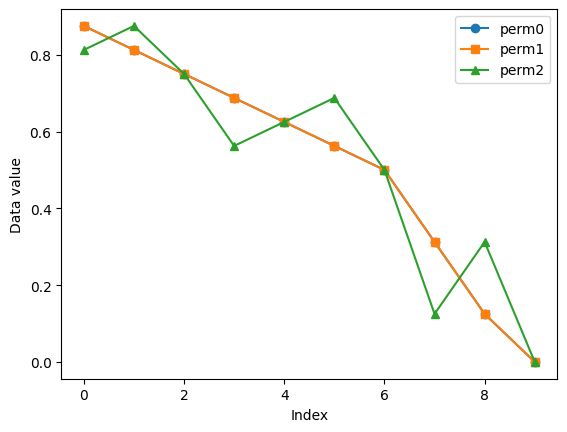

In [15]:
mean_winning = group_comparator.comparison_matrix.mean(axis=1)
stacked_mean = np.stack([mean_winning[p] for p in [perm1, perm2, perm3]], axis=0)
for mean in stacked_mean:
    print(mean.tolist())
# Plot distribution
import matplotlib.pyplot as plt

for i, (data, marker) in enumerate(zip(stacked_mean ,'os^')):
    plt.plot(data, marker=marker, label=f'perm{i}')

plt.xlabel("Index")
plt.ylabel("Data value")
plt.legend()
plt.show()

In [168]:
perm = np.argsort(mean_winning)[::-1]
','.join(np.array(group)[perm])

'P,L,K,M,J,G,D,C,B,E,O,A,F,N,H,I'

In [160]:
sorted(group_comparator.comparison_matrix.mean(axis=1).tolist())

[0.25,
 0.3125,
 0.3125,
 0.375,
 0.375,
 0.375,
 0.375,
 0.4375,
 0.5,
 0.5,
 0.5625,
 0.5625,
 0.5625,
 0.625,
 0.6875,
 0.6875]